In [1]:
# Import necessary libraries
import sys
import logging
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

from pathlib import Path

In [2]:
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
# Set Base Directory
base_dir = Path.cwd().parent  # Moves one level up from current working directory

# Data Directory
data_dir = base_dir / '02_Data'

In [4]:
# Load datasets
train = pd.read_csv(data_dir / "Train.csv")
test = pd.read_csv(data_dir / "Test.csv")
toilets = pd.read_csv(data_dir / "toilets.csv")
waste_management = pd.read_csv(data_dir / "waste_management.csv")
water_sources = pd.read_csv(data_dir / "water_sources.csv")

# EDA

### Shapes

In [5]:
train.shape

(23848, 9)

In [6]:
test.shape

(4872, 8)

In [7]:
toilets.shape

(10680, 43)

In [8]:
waste_management.shape

(5100, 43)

In [9]:
water_sources.shape

(10560, 43)

### Non-null counts and Dtypes

In [10]:
print("Train Data Info\n")
train.info()

Train Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23848 entries, 0 to 23847
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             23848 non-null  object 
 1   Total                          23847 non-null  float64
 2   Location                       23848 non-null  object 
 3   Category_Health_Facility_UUID  23848 non-null  object 
 4   Disease                        23848 non-null  object 
 5   Month                          23848 non-null  int64  
 6   Year                           23848 non-null  int64  
 7   Transformed_Latitude           23848 non-null  float64
 8   Transformed_Longitude          23848 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 1.6+ MB


In [11]:
print("Test Data Info\n")
test.info()

Test Data Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4872 entries, 0 to 4871
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Location                       4872 non-null   object 
 1   Disease                        4872 non-null   object 
 2   Month                          4872 non-null   int64  
 3   Category_Health_Facility_UUID  4872 non-null   object 
 4   Year                           4872 non-null   int64  
 5   Transformed_Latitude           4872 non-null   float64
 6   Transformed_Longitude          4872 non-null   float64
 7   ID                             4872 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 304.6+ KB


### Number of Missing Values

In [12]:
print("Train Data - Number of Missing Values\n")
train.isnull().sum()

Train Data - Number of Missing Values



ID                               0
Total                            1
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

In [13]:
print("Test Data - Number of Missing Values\n")
test.isnull().sum()

Test Data - Number of Missing Values



Location                         0
Disease                          0
Month                            0
Category_Health_Facility_UUID    0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
ID                               0
dtype: int64

### Duplicates

In [14]:
duplicate_count = train.duplicated().sum()
print(duplicate_count)

6675


In [15]:
duplicate_count_test = test.duplicated().sum()
print(duplicate_count_test)

0


### Outliers

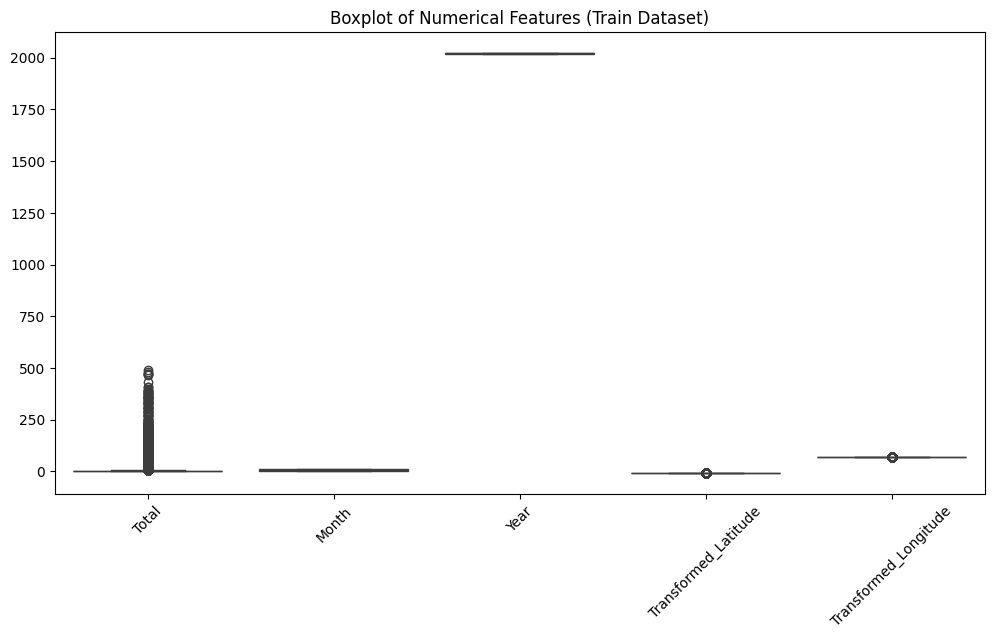

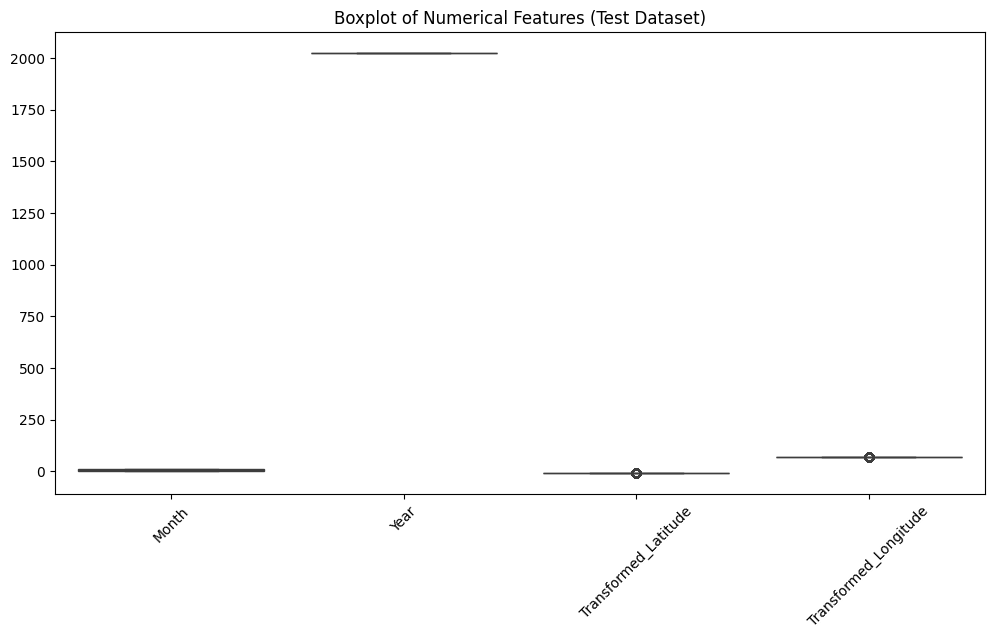

In [16]:
# Function to plot boxplots for numerical features
def plot_boxplots(df, title):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df.select_dtypes(include=['number']))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

# Boxplots
plot_boxplots(train, "Boxplot of Numerical Features (Train Dataset)")
plot_boxplots(test, "Boxplot of Numerical Features (Test Dataset)")


### Outliers Using IQR

In [17]:
def detect_outliers_iqr(data, multiplier=1.5):
    """Detects outliers in a given Pandas Series using the IQR method."""
    q1 = np.percentile(data.dropna(), 25)
    q3 = np.percentile(data.dropna(), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (multiplier * IQR)

    return data[(data < lwr_bound) | (data > upr_bound)].index

### Summary Statistics

In [18]:
print("Train Data - Summary Stats\n")

train.describe()

Train Data - Summary Stats



,Total,Month,Year,Transformed_Latitude,Transformed_Longitude
count,23847.000000,23848.000000,23848.000000,23848.00000,23848.000000
mean,8.355600,6.568643,2020.610282,-8.61252,68.242682
std,28.076713,3.445577,1.133108,0.04251,0.029114
min,0.000000,1.000000,2019.000000,-8.71376,68.169720
25%,0.000000,4.000000,2020.000000,-8.62656,68.224740
50%,0.000000,7.000000,2021.000000,-8.61740,68.237620
75%,3.000000,10.000000,2022.000000,-8.59431,68.257640
max,489.000000,12.000000,2022.000000,-8.49681,68.328390


In [19]:
print("Test Data - Summary Stats\n")

test.describe()

Test Data - Summary Stats



,Month,Year,Transformed_Latitude,Transformed_Longitude
count,4872.000000,4872.0,4872.000000,4872.000000
mean,6.500000,2023.0,-8.609202,68.239384
std,3.452407,0.0,0.041923,0.028248
min,1.000000,2023.0,-8.713760,68.169720
25%,3.750000,2023.0,-8.626560,68.224400
50%,6.500000,2023.0,-8.617375,68.235815
75%,9.250000,2023.0,-8.591610,68.252550
max,12.000000,2023.0,-8.496810,68.328390


### Variable Distribution

In [20]:
# # Plot target variable distribution
# plt.figure(figsize=(10, 5))
# sns.histplot(train['Total'], bins=30, kde=True)
# plt.title("Distribution of Total Variable")
# plt.show()

### Correlation in Train Data

In [21]:
# # Select only numeric columns
# numeric_cols = train.select_dtypes(include=['number'])

# # Compute correlation only for numeric features
# plt.figure(figsize=(12, 6))
# sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
# plt.title("Feature Correlation Heatmap")
# plt.show()


# Preprocessing

## Supplementary Datasets

### Unnecessary Columns

In [22]:
# Drop unnecessary columns from supplementary datasets
for df in [toilets, waste_management, water_sources]:
    df.drop(columns=['Year', 'Month'], inplace=True)

### Missing Values

In [23]:
# Number of Missing Values
toilets.isnull().sum()

10u                      0
10v                      0
2d                       0
2t                       0
evabs                    0
evaow                    0
evatc                    0
evavt                    0
albedo                   0
lshf                     0
lai_hv                   0
lai_lv                   0
pev                      0
ro                       0
src                      0
skt                      0
es                       0
stl1                     0
stl2                     0
stl3                     0
stl4                     0
ssro                     0
slhf                     0
ssr                      0
str                      0
sp                       0
sro                      0
sshf                     0
ssrd                     0
strd                     0
e                        0
tp                       0
swvl1                    0
swvl2                    0
swvl3                    0
swvl4                    0
Transformed_Latitude     0
T

In [24]:
# Number of Missing Values
waste_management.isnull().sum()

10u                      0
10v                      0
2d                       0
2t                       0
evabs                    0
evaow                    0
evatc                    0
evavt                    0
albedo                   0
lshf                     0
lai_hv                   0
lai_lv                   0
pev                      0
ro                       0
src                      0
skt                      0
es                       0
stl1                     0
stl2                     0
stl3                     0
stl4                     0
ssro                     0
slhf                     0
ssr                      0
str                      0
sp                       0
sro                      0
sshf                     0
ssrd                     0
strd                     0
e                        0
tp                       0
swvl1                    0
swvl2                    0
swvl3                    0
swvl4                    0
Transformed_Latitude     0
T

In [25]:
# Number of Missing Values
water_sources.isnull().sum()

10u                       0
10v                       0
2d                        0
2t                        0
evabs                     0
evaow                     0
evatc                     0
evavt                     0
albedo                    0
lshf                      0
lai_hv                    0
lai_lv                    0
pev                       0
ro                        0
src                       0
skt                       0
es                        0
stl1                      0
stl2                      0
stl3                      0
stl4                      0
ssro                      0
slhf                      0
ssr                       0
str                       0
sp                        0
sro                       0
sshf                      0
ssrd                      0
strd                      0
e                         0
tp                        0
swvl1                     0
swvl2                     0
swvl3                     0
swvl4               

In [26]:
# Drop rows with missing latitude and longitude in water sources
water_sources.dropna(subset=['Transformed_Latitude'], inplace=True)

### Prefixes

In [27]:
# Rename columns for clarity
def rename_columns(df, prefix):
    for col in df.columns:
        if col not in ['Month_Year_lat_lon', 'lat_lon']:
            df.rename(columns={col: f"{prefix}_{col}"}, inplace=True)

rename_columns(toilets, "toilet")
rename_columns(waste_management, "waste")
rename_columns(water_sources, "water")

## Train and Test

### Missing Values

In [28]:
# Imputing with Median
train.loc[:, 'Total'] = train['Total'].fillna(train['Total'].median())

# Number of Missing Values
train.isnull().sum()

ID                               0
Total                            0
Location                         0
Category_Health_Facility_UUID    0
Disease                          0
Month                            0
Year                             0
Transformed_Latitude             0
Transformed_Longitude            0
dtype: int64

## Merge Datasets

In [29]:
def find_nearest(data_df, location_df, lat_col, lon_col, id_col):
    # Create a cKDTree for efficient nearest neighbour search
    tree = cKDTree(location_df[[lat_col, lon_col]].values)
    nearest = {}
    # Loop through each data_df and find the nearest site in location_df
    for _, row in data_df.iterrows():
        _, idx = tree.query([row['Transformed_Latitude'], row['Transformed_Longitude']])
        nearest[row['ID']] = location_df.iloc[idx][id_col]
    return nearest


In [30]:
# Ensure unique identifier columns exist in all supplementary datasets
for df, prefix in [(toilets, 'toilet'), (waste_management, 'waste'), (water_sources, 'water')]:
    df[f"{prefix}_Month_Year_lat_lon"] = (
        df[f"{prefix}_Month_Year"] + '_' +
        df[f"{prefix}_Transformed_Latitude"].astype(str) + '_' +
        df[f"{prefix}_Transformed_Longitude"].astype(str)
    )

In [31]:
toilets.head()

,toilet_10u,toilet_10v,toilet_2d,toilet_2t,toilet_evabs,toilet_evaow,toilet_evatc,toilet_evavt,toilet_albedo,toilet_lshf,...,toilet_swvl1,toilet_swvl2,toilet_swvl3,toilet_swvl4,toilet_Transformed_Latitude,toilet_Transformed_Longitude,toilet_Month_Year,lat_lon,Month_Year_lat_lon,toilet_Month_Year_lat_lon
0,-1.006850,-0.714544,293.502,297.417,-0.002489,-0.001031,-0.000989,-3.445890e-08,0.173221,0.650001,...,0.346542,0.335724,0.264359,0.300018,-8.61768,68.24536,1_2019,-8.61768_68.24536,1_2019_-8.61768_68.24536,1_2019_-8.61768_68.24536
1,-1.408560,-0.662555,292.943,297.978,-0.002556,-0.001076,-0.000734,-3.818420e-08,0.173808,0.650001,...,0.254517,0.259918,0.281769,0.296188,-8.61768,68.24536,2_2019,-8.61768_68.24536,2_2019_-8.61768_68.24536,2_2019_-8.61768_68.24536
2,-0.892110,-0.449448,293.250,297.989,-0.002535,-0.000980,-0.000713,-3.678720e-08,0.178823,0.650001,...,0.278152,0.284195,0.261597,0.291672,-8.61768,68.24536,3_2019,-8.61768_68.24536,3_2019_-8.61768_68.24536,3_2019_-8.61768_68.24536
3,-0.392348,0.384925,293.934,296.542,-0.001748,-0.000658,-0.001343,-2.700840e-08,0.180959,0.650017,...,0.385513,0.378616,0.309784,0.288925,-8.61768,68.24536,4_2019,-8.61768_68.24536,4_2019_-8.61768_68.24536,4_2019_-8.61768_68.24536
4,-0.447104,0.581028,292.571,294.726,-0.001374,-0.000462,-0.001139,-2.048910e-08,0.182375,0.650009,...,0.397659,0.400055,0.392654,0.309311,-8.61768,68.24536,5_2019,-8.61768_68.24536,5_2019_-8.61768_68.24536,5_2019_-8.61768_68.24536


In [32]:
# Merge datasets with nearest locations
merged_train_data = train.copy()
merged_test_data = test.copy()
datasets = [
    (toilets, 'toilet', 'toilet_Month_Year_lat_lon'),
    (waste_management, 'waste', 'waste_Month_Year_lat_lon'),
    (water_sources, 'water', 'water_Month_Year_lat_lon'),
]

In [33]:
# Merge Train
for df, prefix, id_col in datasets:
    nearest_train = find_nearest(merged_train_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_train_df = pd.DataFrame(list(nearest_train.items()), columns=['ID', id_col])
    merged_train_data = merged_train_data.merge(nearest_train_df, on="ID").merge(df, on=id_col)

In [34]:
# Merge Test
for df, prefix, id_col in datasets:
    nearest_test = find_nearest(merged_test_data, df, f"{prefix}_Transformed_Latitude", f"{prefix}_Transformed_Longitude", id_col)
    nearest_test_df = pd.DataFrame(list(nearest_test.items()), columns=['ID', id_col])
    merged_test_data = merged_test_data.merge(nearest_test_df, on="ID").merge(df, on=id_col)

In [35]:
merged_train_data.shape

(24376, 135)

In [36]:
merged_test_data.shape

(4956, 134)

### Duplicates, Skewness and Outliers

In [37]:
merged_duplicate_count = merged_train_data.duplicated().sum()
print(merged_duplicate_count)

7204


In [38]:
merged_train_data_with_duplicates = merged_train_data.copy()

In [39]:
# Log_Total before detecting outliers
merged_train_data_with_duplicates["Log_Total"] = np.log1p(merged_train_data_with_duplicates["Total"])

merged_train_data_with_duplicates["Z_Score_Total"] = np.abs(zscore(merged_train_data_with_duplicates["Total"]))
merged_train_data_with_duplicates["Z_Score_Log_Total"] = np.abs(zscore(merged_train_data_with_duplicates["Log_Total"]))

### Outlier Detection Before Removing Duplicates

In [40]:
# Using IQR
outliers_iqr_with_duplicates = merged_train_data_with_duplicates.loc[detect_outliers_iqr(merged_train_data_with_duplicates["Total"])]
outliers_iqr_log_with_duplicates = merged_train_data_with_duplicates.loc[detect_outliers_iqr(merged_train_data_with_duplicates["Log_Total"])]


# Using Z-score
outliers_zscore_with_duplicates = merged_train_data_with_duplicates.loc[merged_train_data_with_duplicates["Z_Score_Total"] > 3]
outliers_zscore_log_with_duplicates = merged_train_data_with_duplicates.loc[merged_train_data_with_duplicates["Z_Score_Log_Total"] > 3]


### Removing Duplicates

In [41]:
# Drop duplicate rows
merged_train_data = merged_train_data.drop_duplicates()

In [42]:
merged_train_data.shape

(17172, 135)

### Outlier Detection After Removing Duplicates

In [43]:
# Log_Total after dropping duplicates
merged_train_data["Log_Total"] = np.log1p(merged_train_data["Total"])

merged_train_data["Z_Score_Total"] = np.abs(zscore(merged_train_data["Total"]))
merged_train_data["Z_Score_Log_Total"] = np.abs(zscore(merged_train_data["Log_Total"]))

In [44]:
# Detect outliers using IQR on Total and Log_Total after dropping duplicates
outliers_iqr_no_duplicates = merged_train_data.loc[detect_outliers_iqr(merged_train_data["Total"])]
outliers_iqr_log_no_duplicates = merged_train_data.loc[detect_outliers_iqr(merged_train_data["Log_Total"])]


# Detect outliers using Z-score on Total and Log_Total after dropping duplicates
outliers_zscore_no_duplicates = merged_train_data.loc[merged_train_data["Z_Score_Total"] > 3]
outliers_zscore_log_no_duplicates = merged_train_data.loc[merged_train_data["Z_Score_Log_Total"] > 3]

In [45]:
outlier_df = pd.DataFrame(
    {
        "Method": ["IQR", "Z-Score"],
        "Total_With_Duplicates": [outliers_iqr_with_duplicates.shape[0], outliers_zscore_with_duplicates.shape[0]],
        "Total_No_Duplicates": [outliers_iqr_no_duplicates.shape[0], outliers_zscore_no_duplicates.shape[0]],
        "Log_Total_With_Duplicates": [outliers_iqr_log_with_duplicates.shape[0], outliers_zscore_log_with_duplicates.shape[0]],
        "Log_Total_No_Duplicates": [outliers_iqr_log_no_duplicates.shape[0], outliers_zscore_log_no_duplicates.shape[0]]
    }
)


print("Number of Outliers With and Without Duplicates in Total and Log_Total")

outlier_df

Number of Outliers With and Without Duplicates in Total and Log_Total


,Method,Total_With_Duplicates,Total_No_Duplicates,Log_Total_With_Duplicates,Log_Total_No_Duplicates
0,IQR,4733,2355,1901,41
1,Z-Score,455,315,208,58


### Train Data Set (Review)

In [46]:
merged_train_data.head()

,ID,Total,Location,Category_Health_Facility_UUID,Disease,Month,Year,Transformed_Latitude,Transformed_Longitude,toilet_Month_Year_lat_lon,...,water_swvl3,water_swvl4,water_Transformed_Latitude,water_Transformed_Longitude,water_Month_Year,lat_lon,Month_Year_lat_lon,Log_Total,Z_Score_Total,Z_Score_Log_Total
0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Dysentery,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589,0.00000,0.354932,0.724124
1,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Typhoid,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589,0.00000,0.354932,0.724124
2,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Diarrhea,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589,0.00000,0.354932,0.724124
5,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,0.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Schistosomiasis,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589,0.00000,0.354932,0.724124
6,ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...,6.0,ID_3a11929e-3317-476d-99f7-1bd9fb58f018,a9280aca-c872-46f5-ada7-4a7cc31cf6ec,Malaria,12,2022,-8.62982,68.23267,4_2020_-8.62979_68.23582,...,0.281708,0.24585,-8.62966,68.23589,12_2023,-8.62966_68.23589,12_2023_-8.62966_68.23589,1.94591,0.170384,0.568363


In [47]:
# train = train.drop(["Z_Score_Total","Z_Score_Log_Total"], axis=1)
# train.head()

### Impute Outliers with Median

In [50]:
# train_less_outliers = merged_train_data.copy()

In [ ]:
# sys.exit("Execution stopped here!")

In [48]:
# # Impute IQR outliers with median
# for col in ["Total", "Log_Total"]:
#     median_value = train_less_outliers[col].median()
#     train_less_outliers.loc[detect_outliers_iqr(train_less_outliers[col]), col] = median_value

# # Impute Z-score outliers with median
# for col in ["Total", "Log_Total"]:
#     median_value = train_less_outliers[col].median()
#     train_less_outliers.loc[train_less_outliers[f"Z_Score_{col}"] > 3, col] = median_value


In [ ]:
# # Step 1: Detect Outliers Again After Imputation
# outliers_iqr_after = {
#     "Total": len(detect_outliers_iqr(train_less_outliers["Total"])),
#     "Log_Total": len(detect_outliers_iqr(train_less_outliers["Log_Total"]))
# }

# outliers_zscore_after = {
#     "Total": (train_less_outliers["Z_Score_Total"] > 3).sum(),
#     "Log_Total": (train_less_outliers["Z_Score_Log_Total"] > 3).sum()
# }

# # Step 2: Create DataFrame to Compare Outliers Before and After Imputation
# outliers_after_df = pd.DataFrame(
#     {
#         "Method": ["IQR", "Z-Score"],
#         "Total_After_Imputation": [outliers_iqr_after["Total"], outliers_zscore_after["Total"]],
#         "Log_Total_After_Imputation": [outliers_iqr_after["Log_Total"], outliers_zscore_after["Log_Total"]]
#     }
# )

# # Step 3: Print Results
# print("Outliers Remaining After Imputation:")
# print(outliers_after_df)


## Start modeling

#### Make predictions on test